# Hopfield - New energy function for continuous-valued patterns and states
So far, we have explored the standard Hopfield networks and an improved version that helps distinguish between correlated patterns. But still, it only works with polar patterns, i.e., $x_i \in \{1, -1\}^d$. In this notebook, the implementation abstracts to continuous values patterns.

References:
* https://ml-jku.github.io/hopfield-layers/
* [Hopfield Networks is All you Need](https://arxiv.org/abs/2008.02217)

## New energy function
The new Energy Function proposed to contemplate continuous-valued patterns is as follows:

$$
E = - \mathrm{lse}(\beta, X^T\xi) + \frac{1}{2}\xi^T\xi+\beta^{-1}\mathrm{log}N+\frac{1}{2}M^2
$$

where $N$ is the number of **continuous** stored patterns by matrix $X$, and $M$ is the largest norm of all stored patterns.

## New update rule
The new updated rule derived from the new energy function is as follows:
$$
\xi^{new} = X\mathrm{softmax}(\beta X^T \xi)
$$

## Key Remakrs
1. The main aspect of the new paper is the fact that the new update rule will converge to the energy minima for a given state pattern **in just one step!** This is opposed to previous hopefield proposals as it was still an iterative process, minimizing the energy by repeatedly applying the update rule to the state pattern. This fast convergence is the most remarkable aspect of the new update rule.
2. In the pattern retrieval case, it is **very important** that the stored patterns be normalized, i.e., $\frac{\overrightarrow{\mathbf{v}}}{\lVert \overrightarrow{\mathbf{v}} \rVert}$. All stored patterns norm should be `1`, otherwise, during pattern retrieval the pattern with the largest norm will impose over all others making it unsuccessful.

With above modifications, we proceed to the implementation as follows:

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize

width, height = 128, 128

def normalize(x):
    """Normalize between values [-1.0, 1.0]
    This is NOT vector normalization.
    """
    x = 2 * ( (x - np.min(x)) / (np.max(x) - np.min(x))) - 1
    return x

def vec_normalize(x, axis=None):
    """Normalize vectors
    This is vector normalization, it will make
    all column vectors to have norm=1.0, this is
    the mandatory step for the pattern retrieval
    to work.
    """
    if axis is None:
        norm_x = np.linalg.norm(x)
    else:        
        norm_x = np.apply_along_axis(np.linalg.norm, axis=axis, arr=x)
    return x / norm_x

def load_images(im_ids, cols=4):
    imgs = [image.imread(f'subset_gray/{id}') for id in im_ids]
    imgs = [resize(img, (width, height)) for img in imgs]
    # imgs = [normalize(img) for img in imgs] # normalize values between -1. and 1.
    # imgs = [vec_normalize(img) for img in imgs] # vector normalize
    n_imgs = len(imgs)
    rows = n_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize=(16, 6))
    axes = ax.ravel()
    fig.suptitle("Stored patterns $X$")
    for idx in range(n_imgs):
        axes[idx].imshow(imgs[idx], cmap='gray')
    plt.show()
    return imgs

In [114]:
def assert_similar(a, b, delta=0.99):
    numerator = a.T @ b
    denominator = np.linalg.norm(a) * np.linalg.norm(b)
    cos_similarity = numerator / denominator
    assert cos_similarity >= delta, f"vectors do not similar enough. Similarity={cos_similarity}, Threshold={delta}"

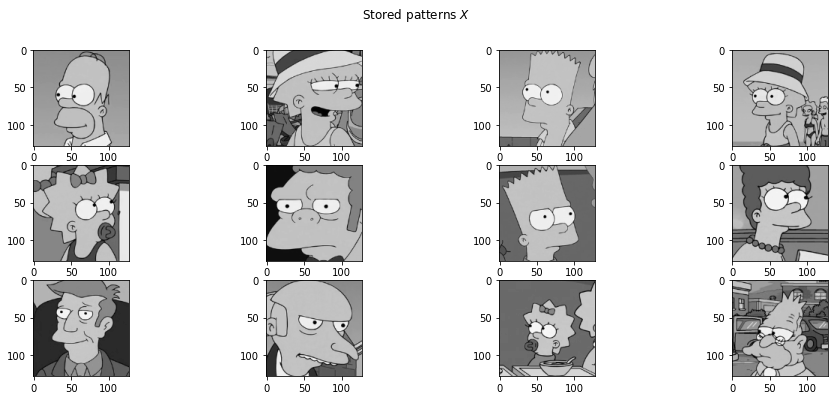

In [103]:
im_ids = ['13.png', '8.png', '28.png', '16.png', '18.png', '50.png', '67.png', '83.png', '115.png', '203.png', '345.png', '953.png']
set1 = load_images(im_ids)

In [104]:
from scipy.special import logsumexp

def energy(X, state, b, N, M):
    """New energy function as per
    Hofield networks is all you need."""
    return -logsumexp(X.T @ state, b=b) + 0.5 * state.T @ state + (b ** -1) * np.log(N) + 0.5 * M ** 2

In [105]:
from scipy.special import softmax

def retrieve_pattern(et, X, b: float = 1.0, steps: int = 200):
    N = X.shape[1]
    M = np.max(np.apply_along_axis(np.linalg.norm, 0, X))
    energy_old = np.infty
    energy_new = energy(X, et, b, N, M)
    iteration = 0
    
    while (energy_old > energy_new) and iteration < steps:
        iteration += 1
        energy_old = energy_new
        et = X @ softmax(b * X.T @ et) # new update rule
        energy_new = energy(X, et, b, N, M)
    
    print(f"Stopped at iteration {iteration}")
    return et


In [106]:
def plot_retrieval(e0, et):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax = axes.ravel()
    ax[0].imshow(e0.reshape(width, height), cmap='binary_r')
    ax[0].set_title('Initial state pattern')
    ax[1].imshow(et.reshape(width, height), cmap='binary_r')
    ax[1].set_title('Retrieved pattern')
    plt.show()


In [132]:
X = set1[0].flatten().reshape(-1, 1)
X = vec_normalize(normalize(X))

### Single point test - Single pattern, querying with full pattern

Stopped at iteration 1


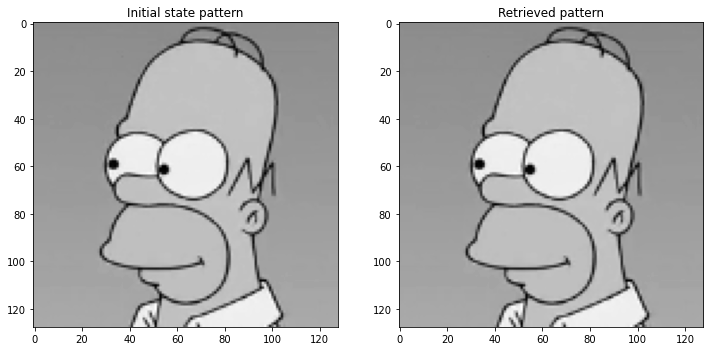

In [133]:
homer = X[:, 0].reshape(-1, 1)
et = retrieve_pattern(homer.copy(), X)
plot_retrieval(homer, et)
assert_similar(homer, et)

### Single point test - Single pattern, querying with masked pattern

Stopped at iteration 1


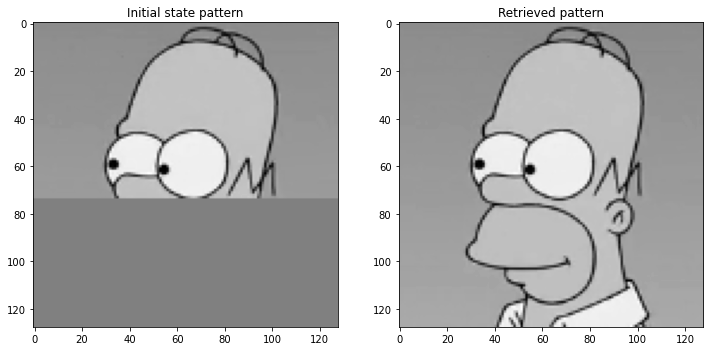

In [134]:
masked_homer = homer.copy()
e0 = masked_homer.reshape(width, height)
e0[width // 2+10: width, 0: height] = 0
e0 = e0.flatten().reshape(-1, 1)
et = retrieve_pattern(e0.copy(), X, b=10., steps=1)
plot_retrieval(e0, et)
assert_similar(homer, et)

### Single point test - Multiple patterns, querying with full pattern

Stopped at iteration 1


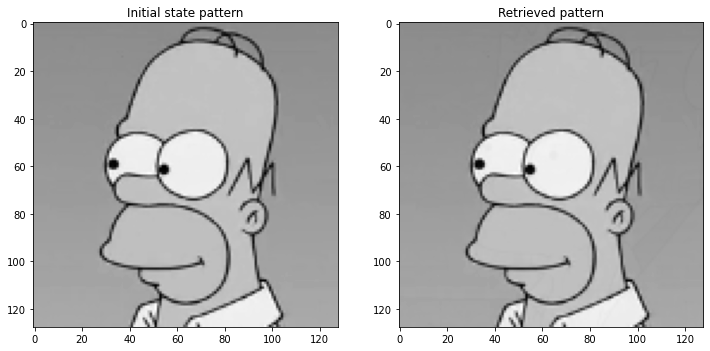

In [135]:
X = np.array([img.flatten() for img in set1]).T
X = vec_normalize(normalize(X), axis=0)
et = retrieve_pattern(homer.copy(), X, 10., steps=1)
plot_retrieval(homer, et)
assert_similar(homer, et)

### Single point test - Multiple patterns, querying with masked pattern

Stopped at iteration 1


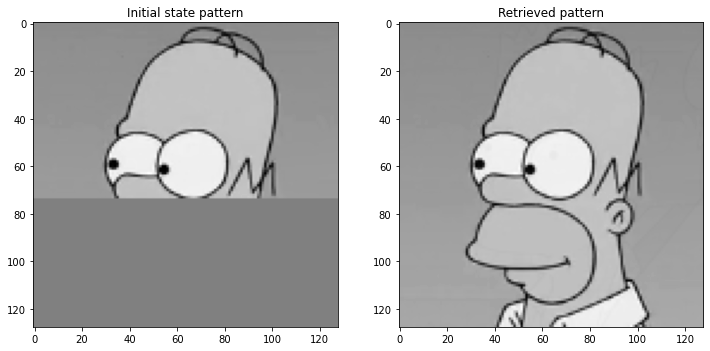

In [163]:
et = retrieve_pattern(e0.copy(), X, b=25., steps=1)
plot_retrieval(e0, et)
assert_similar(homer, et)

**Note:** To the human eye, homer is (almost) perfectly retrieved, but in reality, there might be some pixels with different values, we can check however the cosine similarity of the result and the expected pattern and we will see that in fact, if not equal, they will be very close to each other. One of the possible reasons of the "imperfect" pattern retrieval is the temperature parameter $\beta$.

### The temperature parameter $\beta$
The temperature parameter $\beta$ regulates how separable are similar patterns or if is desirable to obtain a metastable state instead. High values of $\beta$ correspond to low temperature and mean that teh attraction basins of the individual patterns remain separated. In contrast, low values of $\beta$ correspond to high temperature and the formation of metastables becomes more likely. Metastable states can be thought of an average of similar patterns.

Here we try with different values for $\beta$ and see the effect on the retrieved pattern. We can cleary see that a higher value yields a clearer homer retrieval.

In [164]:
betas = [0.25, 0.50, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
retrieved_paterns = []
for beta in betas:
    retrieved_paterns.append(retrieve_pattern(e0.copy(), X, b=beta, steps=1))

Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1
Stopped at iteration 1


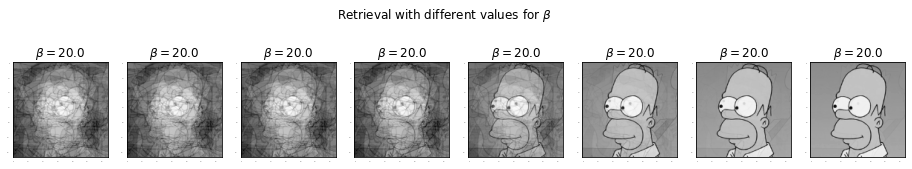

In [177]:
fig, ax = plt.subplots(1, len(betas), figsize=(16, 3))
axes = ax.ravel()
fig.suptitle(f"Retrieval with different values for $\\beta$")
for idx in range(len(betas)):
    et = retrieved_paterns[idx].reshape(width, height)
    axes[idx].imshow(et, cmap='gray')
    axes[idx].set_title(f"$\\beta={beta}$")
    axes[idx].tick_params(axis='both', which='both', labelsize=0, length=0)
    

plt.show()

One important aspect here is that, we only needed a single update to retrieve the pattern from the stored patterns, this is excellent from the computational stand point as it is no longer needed a loop and recalculating the energy function to keep minimizing it. It is guaranteed that a single update will minimize the energy function. The implementation here however preserved the classic loop from previous notebooks to ease the reading and appreciate the changes from previous methods. But from here onwards, the loop like implementation and the energy function calculation will no longer be needed.